In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
# number of logins each week by user
logins_by_week = engagement.groupby('user_id').resample('1W', on='time_stamp').sum().drop(columns='user_id').reset_index()
logins_by_week.head()

,user_id,time_stamp,visited
0,1,2014-04-27,1
1,2,2013-11-17,1
2,2,2013-11-24,0
3,2,2013-12-01,1
4,2,2013-12-08,0


In [5]:
# if more than 3 logins in any week, adopted user == 1
logins_by_week.loc[logins_by_week['visited']>=3, 'adopted_user'] = 1

# find user IDs for adopted users
adopted_users = logins_by_week.groupby('user_id').sum()
adopted_users = adopted_users[adopted_users['adopted_user']>0].drop(columns='adopted_user')

# going to merge with user data, so make it easy to find these users later
adopted_users['adopted_user'] = 1
adopted_users = adopted_users.drop(columns='visited')
adopted_users.head()

,adopted_user
user_id,
2,1
10,1
20,1
33,1
42,1


In [6]:
adopted_user_data = users.merge(adopted_users, how='left', left_on='object_id', right_index=True)
adopted_user_data['adopted_user'] = adopted_user_data['adopted_user'].fillna(0)
adopted_user_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [7]:
# find active days
adopted_user_data['creation_time'] = pd.to_datetime(adopted_user_data['creation_time'])
adopted_user_data['last_session_creation_time'] = pd.to_datetime(adopted_user_data['last_session_creation_time'], unit='s')
adopted_user_data['active_days'] = (adopted_user_data['last_session_creation_time'] - adopted_user_data['creation_time'])/np.timedelta64(1, 'D')
adopted_user_data['active_days'] = adopted_user_data['active_days'].fillna(0)
adopted_user_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,active_days
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0,5.0


In [8]:
# prepare data for modeling
modeling_data = adopted_user_data[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
                                   'org_id', 'invited_by_user_id', 'adopted_user', 'active_days']]

# convert invited to 1 or 0, was or was not invited
modeling_data.loc[modeling_data['invited_by_user_id'].notna(), 'invited'] = 1
modeling_data['invited'] = modeling_data['invited'].fillna(0)
modeling_data = modeling_data.drop(columns='invited_by_user_id')

# get dummies for creation source
modeling_data = modeling_data.merge(pd.get_dummies(modeling_data['creation_source']), left_index=True, right_index=True).drop(columns='creation_source')

# get dummies for org_id - this is actually categorical, not continuous
modeling_data = modeling_data.merge(pd.get_dummies(modeling_data['org_id'], prefix='org_id'), left_index=True, right_index=True).drop(columns='org_id')
modeling_data.head()

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,active_days,invited,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
0,1,0,0.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1.0,136.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.0,0.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0.0,1.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0.0,5.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# most users do not adopt
modeling_data['adopted_user'].value_counts(normalize=True)

0.0    0.879583
1.0    0.120417
Name: adopted_user, dtype: float64

In [10]:
# start with logistic regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(modeling_data.drop(columns='adopted_user'),
                                                    modeling_data['adopted_user'],
                                                    random_state=5)

lr = LogisticRegression(solver='liblinear', random_state=5)
lr.fit(X_train, y_train)

# print optimal paramaters and accuracy metrics
print('Accuracy score: {:.4f}'.format(accuracy_score(lr.predict(X_test), y_test)))
print('AUC: {:.4f}'.format(roc_auc_score(y_test, lr.predict(X_test))))

Accuracy score: 0.9787
AUC: 0.9340


In [11]:
# what is accuracy if all are classified as not adopted?
print('Default accuracy score: {:.4f}'.format(accuracy_score([0 for i in range(len(y_test))], y_test)))
print('Default AUC: {:.4f}'.format(roc_auc_score(y_test, [0 for i in range(len(y_test))])))

Default accuracy score: 0.8730
Default AUC: 0.5000


Text(0.5, 1.0, 'Logistic Regression ROC Curve')

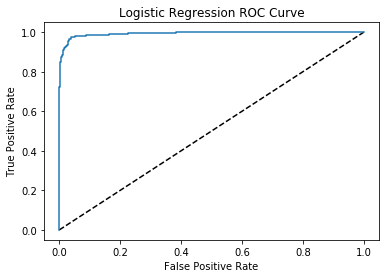

In [12]:
y_pred_prob = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')

Tuned logistic regression parameter: {'C': 0.1}
Accuracy score: 0.9777
AUC: 0.9323


Text(0.5, 1.0, 'Logistic Regression ROC Curve')

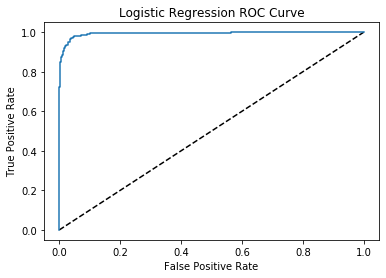

In [13]:
# lets tune the model

# hyperparameter grid
Cs = [0.001, 0.1, 1, 10, 100]
param_grid = {'C': Cs}

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(modeling_data.drop(columns='adopted_user'),
                                                    modeling_data['adopted_user'],
                                                    random_state=5)

lr = LogisticRegression(solver='liblinear', random_state=5)
gs = GridSearchCV(lr, param_grid, cv=5)
gs.fit(X_train, y_train)

# print optimal paramaters and accuracy metrics
print("Tuned logistic regression parameter: {}".format(gs.best_params_))
print('Accuracy score: {:.4f}'.format(accuracy_score(gs.predict(X_test), y_test)))
print('AUC: {:.4f}'.format(roc_auc_score(y_test, gs.predict(X_test))))

y_pred_prob = gs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')

In [14]:
# cross validate
from sklearn.model_selection import cross_val_score

X = modeling_data.drop(columns='adopted_user')
y = modeling_data['adopted_user']

lr_cvs = LogisticRegression(solver='liblinear', C=0.1, random_state=5)
scores = cross_val_score(lr_cvs, X, y, cv=5)

print('Accuracy: {:.4f} (+/- {:.4f})'.format(scores.mean(), scores.std()*2))

Accuracy: 0.9778 (+/- 0.0052)


In [15]:
# tuned model
X_train, X_test, y_train, y_test = train_test_split(modeling_data.drop(columns='adopted_user'),
                                                    modeling_data['adopted_user'],
                                                    random_state=5)

lr = LogisticRegression(solver='liblinear', C=0.1, random_state=5)
lr.fit(X_train, y_train)

# print optimal paramaters and accuracy metrics
print('Accuracy score: {:.4f}'.format(accuracy_score(lr.predict(X_test), y_test)))
print('AUC: {:.4f}'.format(roc_auc_score(y_test, lr.predict(X_test))))

Accuracy score: 0.9777
AUC: 0.9323


In [16]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, lr.predict(X_test), labels=[0,1]))

,0,1
0,2601,18
1,49,332


In [17]:
# look at coefficients for each feature
feat_importance = pd.DataFrame(zip(modeling_data.drop(columns='adopted_user').columns, lr.coef_[0]), columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)

# convert logit (coefficients) into probability of predicting adopted users
feat_importance['odds'] = np.exp(feat_importance['Coefficient'])
feat_importance['probability'] = (feat_importance['odds'])/(feat_importance['odds']+1)

# show features with higher or lower odds than 1:1 of predicting users who DON'T adopt
feat_importance[(feat_importance['odds']>1.15) | (feat_importance['odds']<0.85)]

,Feature,Coefficient,odds,probability
127,org_id_118,0.175066,1.191325,0.543655
128,org_id_119,0.174707,1.190897,0.543566
376,org_id_367,0.162488,1.176434,0.540533
105,org_id_96,0.160205,1.173751,0.539966
274,org_id_265,0.156437,1.169337,0.539030
182,org_id_173,0.156314,1.169193,0.538999
44,org_id_35,0.155110,1.167786,0.538700
164,org_id_155,0.152425,1.164655,0.538033
58,org_id_49,0.148361,1.159932,0.537022
388,org_id_379,-0.177135,0.837666,0.455832


In [18]:
# tuned model with higher odds
feats = feat_importance.loc[(feat_importance['odds']>1.15) | (feat_importance['odds']<0.85), 'Feature'].to_list()
X_train, X_test, y_train, y_test = train_test_split(modeling_data[feats],
                                                    modeling_data['adopted_user'],
                                                    random_state=5)

lr_short = LogisticRegression(solver='liblinear', C=0.1)
lr_short.fit(X_train, y_train)

# print optimal paramaters and accuracy metrics
print('Accuracy score: {:.4f}'.format(accuracy_score(lr_short.predict(X_test), y_test)))
print('AUC: {:.4f}'.format(roc_auc_score(y_test, lr_short.predict(X_test))))

Accuracy score: 0.8730
AUC: 0.5000


In [19]:
# experimented with some random features and found that active days can be the only information used
X_train, X_test, y_train, y_test = train_test_split(modeling_data[['active_days']],
                                                    modeling_data['adopted_user'],
                                                    random_state=5)

lr_final = LogisticRegression(solver='liblinear', C=0.1)
lr_final.fit(X_train, y_train)

# print optimal paramaters and accuracy metrics
print('Accuracy score: {:.4f}'.format(accuracy_score(lr_final.predict(X_test), y_test)))
print('AUC: {:.4f}'.format(roc_auc_score(y_test, lr_final.predict(X_test))))

Accuracy score: 0.9783
AUC: 0.9338
